<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

# Import dependencies and load data

In [143]:
import pandas as pd
import numpy as np
import sys
import operator
from scipy import stats
import requests
from IPython.display import HTML
import matplotlib.pylab as plt
import warnings
import geopandas as gpd
from fiona.crs import from_epsg
import statsmodels.formula.api as smf

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/zhoubaoling/anaconda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt', 'var']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
# These are the "Tableau 20" colors as RGB.
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
 
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)

plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['font.serif'] = 'Arial'
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['figure.frameon'] = False
plt.rcParams['axes.prop_cycle'] = cycler('color',tableau20)
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.fontsize'] = 14

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
# Read data
df_xls = pd.read_excel(r'http://www.nyc.gov/html/gbee/downloads/excel/nyc_benchmarking_disclosure_data_reported_in_2016.xlsx')

# Convert to .csv
df_xls.to_csv(r'..\data\nyc_benchmarking_disclosure_data_reported_in_2016.csv', encoding='utf-8')
df = pd.read_csv(r'..\data\nyc_benchmarking_disclosure_data_reported_in_2016.csv')

In [5]:
df.head()

,Unnamed: 0,Record Number,Order,"NYC Borough, Block and Lot (BBL)",Co-reported BBL Status,BBLs Co-reported,Reported NYC Building Identification Numbers (BINs),Property Name,Parent Property Id,Parent Property Name,Street Number,Street Name,Zip Code,Borough,DOF Benchmarking Submission Status,Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type,Largest Property Use Type - Gross Floor Area (ft²),2nd Largest Property Use Type,2nd Largest Property Use - Gross Floor Area (ft²),3rd Largest Property Use Type,3rd Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings - Self-reported,Occupancy,Metered Areas (Energy),Metered Areas (Water),ENERGY STAR Score,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Source EUI (kBtu/ft²),Weather Normalized Source EUI (kBtu/ft²),Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),District Steam Use (kBtu),District Hot Water Use (kBtu),District Chilled Water Use (kBtu),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),DOF Property Floor Area (ft²),Property GFA - Self-reported (ft²),Water Use (All Water Sources) (kgal),Municipally Supplied Potable Water - Indoor Intensity (gal/ft²),Release Date,DEP Provided Water Use (kgal),Automatic Water Benchmarking Eligible,Reported Water Method
0,0,4113711.0,1,1.003360e+09,NaN,NaN,1088884,16 Bialystoker Place,Not Applicable: Standalone Property,Not Applicable: Standalone Property,15.0,BIALYSTOKER PLACE,10002.0,Manhattan,In Compliance,Multifamily Housing,Multifamily Housing,Multifamily Housing,98000.0,Not Available,Not Available,Not Available,Not Available,1982,1.0,100.0,Whole Building,Not Available,87.0,73.7,74.4,5.3,0.6,115.0,115.7,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,5463399.1,55261.4,1762214.1,516475.3,436.3,290.2,146.1,98052.0,98000.0,NaN,NaN,2016-04-13 11:08:48,NaN,NaN,NaN
1,1,4630135.0,2,1.010618e+09,NaN,NaN,1026728,(7478) - 432 West 52nd Street Condominium,Not Applicable: Standalone Property,Not Applicable: Standalone Property,432.0,WEST 52 STREET,10019.0,Manhattan,In Compliance,Multifamily Housing,Multifamily Housing,Multifamily Housing,57401.0,Not Available,Not Available,Not Available,Not Available,1950,1.0,95.0,Whole Building,Whole Building,79.0,51.3,50.9,7.5,0.3,108.8,107.1,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,1437732.8,14515.6,1507302.8,431480.2,201.4,76.4,125.0,58851.0,57401.0,768.5,13.39,2016-04-26 21:52:05,NaN,Not Eligible,NaN
2,2,4626594.0,3,1.014270e+09,NaN,NaN,1043974,(9250) - 250 East 73rd Street,Not Applicable: Standalone Property,Not Applicable: Standalone Property,1393.0,2 AVENUE,10021.0,Manhattan,In Compliance,Multifamily Housing,Multifamily Housing,Multifamily Housing,166433.0,Not Available,Not Available,Not Available,Not Available,1964,1.0,95.0,Whole Building,Whole Building,80.0,44.9,44.5,8.2,0.2,106.7,105.2,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,2739020.0,27390.2,4737201.3,1365852.0,538.4,145.5,392.9,166432.0,166433.0,11901.5,71.51,2016-04-26 22:56:36,11897.0,Eligible,Manual
3,3,4626608.0,4,1.015180e+09,NaN,NaN,1048117,(9141) - 141 East 89th Street,Not Applicable: Standalone Property,Not Applicable: Standalone Property,1341.0,LEXINGTON AVENUE,10128.0,Manhattan,In Compliance,Multifamily Housing,Multifamily Housing,Multifamily Housing,114939.0,Not Available,Not Available,Not Available,Not Available,1960,1.0,95.0,Whole Building,Whole Buil

In [6]:
del df['Unnamed: 0']

# This transformation is in case your system doesn't recognize the current encoding
cols = df.columns.str.replace('\xc2\xb2', '_2')
df.columns = cols

In [7]:
df.columns

Index(['Record Number', 'Order', 'NYC Borough, Block and Lot (BBL)',
       'Co-reported BBL Status', 'BBLs Co-reported',
       'Reported NYC Building Identification Numbers (BINs)', 'Property Name',
       'Parent Property Id', 'Parent Property Name', 'Street Number',
       'Street Name', 'Zip Code', 'Borough',
       'DOF Benchmarking Submission Status',
       'Primary Property Type - Self Selected',
       'List of All Property Use Types at Property',
       'Largest Property Use Type',
       'Largest Property Use Type - Gross Floor Area (ft²)',
       '2nd Largest Property Use Type',
       '2nd Largest Property Use - Gross Floor Area (ft²)',
       '3rd Largest Property Use Type',
       '3rd Largest Property Use Type - Gross Floor Area (ft²)', 'Year Built',
       'Number of Buildings - Self-reported', 'Occupancy',
       'Metered Areas (Energy)', 'Metered Areas  (Water)', 'ENERGY STAR Score',
       'Site EUI (kBtu/ft²)', 'Weather Normalized Site EUI (kBtu/ft²)',
       'Wea

# Data inspection

### Question: Show the top 5 mostly encountered building typologies

In [312]:
mydict = dict(zip(df.groupby('Primary Property Type - Self Selected')['Order'].count().index, 
         df.groupby('Primary Property Type - Self Selected')['Order'].count().values))

# show top 5 mostly encountered building typologies
sorted(mydict.items(), key=operator.itemgetter(1), reverse=True)[:6]

[('Multifamily Housing', 8369)]

In [9]:
df = df[df['Primary Property Type - Self Selected'] == 'Multifamily Housing']

In [10]:
df.describe()

,Record Number,Order,"NYC Borough, Block and Lot (BBL)",Street Number,Zip Code,Largest Property Use Type - Gross Floor Area (ft²),Number of Buildings - Self-reported,Occupancy,ENERGY STAR Score,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Source EUI (kBtu/ft²),Weather Normalized Source EUI (kBtu/ft²),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),DOF Property Floor Area (ft²),Property GFA - Self-reported (ft²),Water Use (All Water Sources) (kgal),Municipally Supplied Potable Water - Indoor Intensity (gal/ft²),DEP Provided Water Use (kgal)
count,8.699000e+03,8699.000000,8.698000e+03,6978.000000,8487.000000,8.699000e+03,8699.000000,8699.000000,7513.000000,8654.000000,7440.000000,8406.000000,7458.000000,8654.000000,7440.000000,7.914000e+03,7.458000e+03,8.643000e+03,8.406000e+03,8.669000e+03,8.669000e+03,8.679000e+03,8.487000e+03,8.699000e+03,5.499000e+03,4956.000000,4560.000000
mean,3.476663e+06,6351.661800,2.225283e+09,1108.404271,10610.728879,1.467861e+05,1.490746,99.616623,56.629842,405.938456,448.661250,13.919153,2.238898,548.974451,592.683306,2.991518e+07,3.078148e+05,4.536019e+06,1.280868e+06,4.093800e+03,1.628570e+03,2.462726e+03,1.405344e+05,1.499596e+05,1.193724e+04,94.932849,6801.782149
std,8.229126e+05,3267.420728,1.181873e+09,1694.046711,568.795592,2.299528e+05,4.153277,3.358280,30.477155,9520.852245,10224.456799,228.398920,95.844071,10564.343498,11268.237888,1.347821e+09,1.387439e+07,5.199372e+07,1.493466e+07,8.535570e+04,6.841710e+04,5.095997e+04,2.599077e+05,2.329603e+05,8.786550e+04,860.237215,7047.573041
min,1.443214e+06,1.000000,1.000088e+09,1.000000,10001.000000,5.800000e+01,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.002800e+04,5.800000e+01,0.000000e+00,0.000000,1.000000
25%,2.742914e+06,3765.000000,1.014960e+09,170.000000,10028.000000,6.510000e+04,1.000000,100.000000,32.000000,67.900000,68.100000,3.700000,0.100000,102.200000,102.500000,1.249754e+06,1.255802e+04,9.817544e+05,2.834028e+05,3.419000e+02,2.225000e+02,8.130000e+01,6.402000e+04,6.620950e+04,3.146700e+03,35.070000,3200.725000
50%,3.114529e+06,6373.000000,2.032490e+09,520.000000,10459.000000,8.821400e+04,1.000000,100.000000,61.000000,82.900000,82.700000,4.700000,0.500000,123.800000,123.600000,4.429401e+06,4.500590e+04,1.539532e+06,4.431600e+05,4.928000e+02,3.364000e+02,1.286000e+02,8.673400e+04,8.958000e+04,5.100200e+03,50.665000,5107.200000
75%,4.384553e+06,9181.500000,3.065408e+09,1546.750000,11226.000000,1.452840e+05,1.000000,100.000000,83.000000,101.100000,100.300000,6.600000,0.700000,151.200000,150.325000,7.227774e+06,7.297015e+04,3.000909e+06,8.653078e+05,8.164000e+02,5.337000e+02,2.622500e+02,1.432930e+05,1.480205e+05,8.046100e+03,75.797500,7995.950000
max,5.053345e+06,11971.000000,5.054918e+09,76179.000000,11694.000000,6.940450e+06,161.000000,100.000000,100.000000,801504.700000,798135.700000,10510.900000,7981.000000,841652.400000,838112.300000,1.101676e+11,1.101676e+09,3.729784e+09,1.093137e+09,5.860677e+06,5.852949e+06,2.193799e+06,8.512479e+06,6.940450e+06,3.638813e+06,52143.200000,129781.600000


In [29]:
df.columns

Index(['Record Number', 'Order', 'NYC Borough, Block and Lot (BBL)',
       'Co-reported BBL Status', 'BBLs Co-reported',
       'Reported NYC Building Identification Numbers (BINs)', 'Property Name',
       'Parent Property Id', 'Parent Property Name', 'Street Number',
       'Street Name', 'Zip Code', 'Borough',
       'DOF Benchmarking Submission Status',
       'Primary Property Type - Self Selected',
       'List of All Property Use Types at Property',
       'Largest Property Use Type',
       'Largest Property Use Type - Gross Floor Area (ft²)',
       '2nd Largest Property Use Type',
       '2nd Largest Property Use - Gross Floor Area (ft²)',
       '3rd Largest Property Use Type',
       '3rd Largest Property Use Type - Gross Floor Area (ft²)', 'Year Built',
       'Number of Buildings - Self-reported', 'Occupancy',
       'Metered Areas (Energy)', 'Metered Areas  (Water)', 'ENERGY STAR Score',
       'Site EUI (kBtu/ft²)', 'Weather Normalized Site EUI (kBtu/ft²)',
       'Wea

In [18]:
# Check if there are missing values
print ("Are there missing values? -->", df['Site EUI (kBtu/ft²)'].isnull().values.any())
print ("There are %i missing values out of %i properties (%.1f percent)" %(df['Site EUI (kBtu/ft²)'].isnull().sum(), 
                                                                        len(df), 
                                                                        df['Site EUI (kBtu/ft²)'].isnull().sum()
                                                                          /float(len(df))*100))

Are there missing values? --> True
There are 45 missing values out of 8699 properties (0.5 percent)


# Data cleaning

In [21]:
# Drop nans
df = df.dropna(subset=['Site EUI (kBtu/ft²)'])
print ('Examples after dropping NaNs:', len(df))

Examples after dropping NaNs: 8654


In [23]:
# Drop zero EUI values
df = df[df['Site EUI (kBtu/ft²)']>0]
print ('Examples after dropping zeros:', len(df))

Examples after dropping zeros: 8652


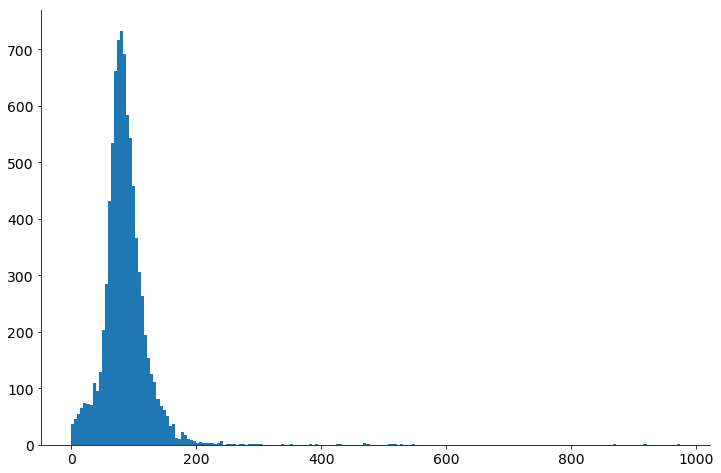

In [24]:
#plt.hist(df['Site EUI (kBtu/ft_2)'], bins=200)
plt.hist(df['Site EUI (kBtu/ft²)'][df['Site EUI (kBtu/ft²)']<1000], bins=200)
plt.show()

__Idea:__ Transform data to approximate the normal distribution --> Select cutoff thresholds based on standard deviations --> Return clean data

![title](../material/transformEUI.png)

### Question: Transform EUI and remove examples falling outside 2 std from the mean

In [25]:
def clean(df):
    """Takes the logarithm of EUI for a particular building type and filters out
    examples that fall outside the threshold of two standard deviations.
    
    Returns outlier-free dataframe."""
    
    df = df[(df.log_eui<np.mean(df.log_eui)+2*np.std(df.log_eui))&(df.log_eui>np.mean(df.log_eui)-2*np.std(df.log_eui))]
    return df

df['eui'] = df['Site EUI (kBtu/ft²)']
df['log_eui'] = np.log10(df.eui)
df = clean(df)
print ('Examples after cleaning EUI:', len(df))

Examples after cleaning EUI: 8369


/Users/zhoubaoling/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/zhoubaoling/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [26]:
df.eui.describe()

count    8369.000000
mean       87.188804
std        29.988660
min        21.000000
25%        69.200000
50%        83.400000
75%       101.300000
max       304.800000
Name: eui, dtype: float64

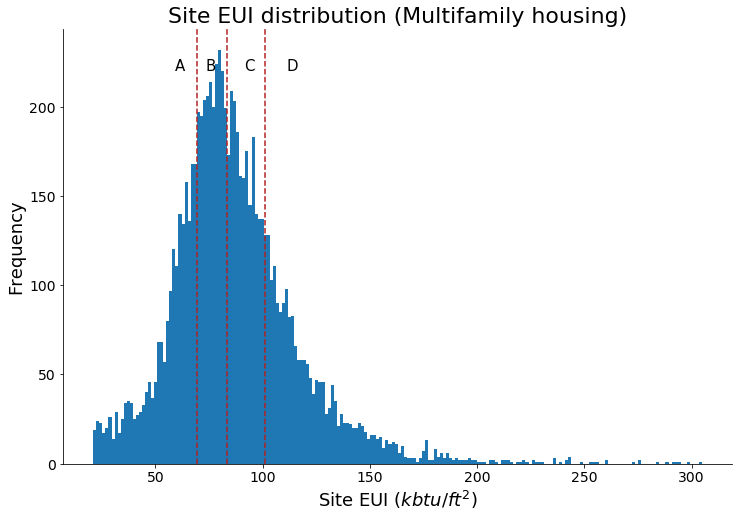

In [27]:
plt.hist(df['Site EUI (kBtu/ft²)'], bins=200)
for label, pos in zip(['A', 'B', 'C'], df['Site EUI (kBtu/ft²)'].describe()[4:7].values):
    plt.axvline(x=pos, color='firebrick', linestyle='--')
    plt.text(pos-10, 220, label, fontsize=15)
plt.text(pos+10, 220, 'D', fontsize=15)
plt.title('Site EUI distribution (Multifamily housing)')
plt.xlabel('Site EUI ($kbtu/ft^{2}$)')
plt.ylabel('Frequency')
plt.show()

# Understanding relationships

In [28]:
def makeCorrPlots(x, y):
    
    """Takes two variables as inputs, fits a univariate linear regression model,
    and outputs the scatter plot, linear fit and correlation coefficient"""
    
    # drop nans
    tmp = df[[x,y]]
    tmp = tmp.dropna()
    
    # fit univariate regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(tmp[x].astype(float), tmp[y])
    
    # plot2
    plt.scatter(tmp[x].astype(float), tmp[y], color=tableau20[0], alpha=0.5)
    plt.plot(tmp[x].astype(float),intercept + slope*tmp[x].astype('float'), color='firebrick')
    plt.title('%s v. %s (corr= %.2f)' %(y, x, np.corrcoef(tmp[x].astype('float'), tmp[y])[0][1]))

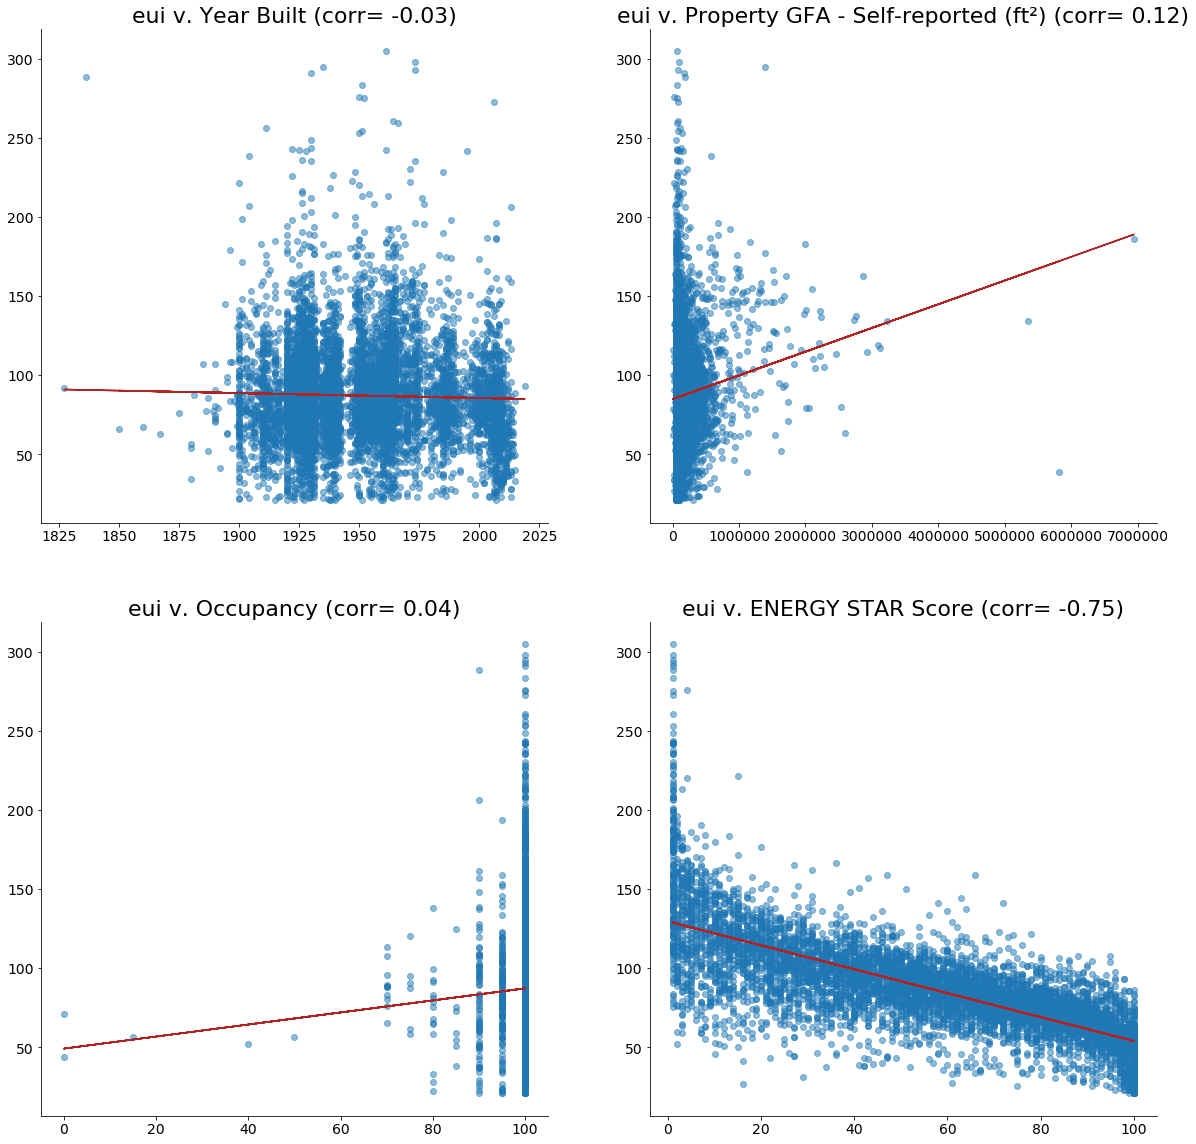

In [30]:
plt.figure(figsize=(20,20))
for i, var in enumerate(['Year Built', 'Property GFA - Self-reported (ft²)', 'Occupancy', 'ENERGY STAR Score'],1):
    plt.subplot(2,2,i)
    makeCorrPlots(var, 'eui')

__Statistical Modeling__



* __Linear v. Non-linear__



* __Predicted efficiency v. Actual efficiency__

In [32]:
df.eui.head()

0     73.7
1     51.3
2     44.9
3     91.3
8    137.2
Name: eui, dtype: float64

## Download PLUTO dataset

In [35]:
#Download the Brooklyn PLUOTO data
#https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page
bk = pd.read_csv('BORO_zip_files_csv/BK.csv')

/Users/zhoubaoling/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (18,19,21,22,23,24,25,63,64,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [36]:
bk.head()

,Borough,Block,Lot,CD,CT2010,CB2010,SchoolDist,Council,ZipCode,FireComp,PolicePrct,HealthArea,SanitBoro,SanitDistrict,SanitSub,Address,ZoneDist1,ZoneDist2,ZoneDist3,ZoneDist4,Overlay1,Overlay2,SPDist1,SPDist2,SPDist3,LtdHeight,SplitZone,BldgClass,LandUse,Easements,OwnerType,OwnerName,LotArea,BldgArea,ComArea,ResArea,OfficeArea,RetailArea,GarageArea,StrgeArea,FactryArea,OtherArea,AreaSource,NumBldgs,NumFloors,UnitsRes,UnitsTotal,LotFront,LotDepth,BldgFront,BldgDepth,Ext,ProxCode,IrrLotCode,LotType,BsmtCode,AssessLand,AssessTot,ExemptLand,ExemptTot,YearBuilt,YearAlter1,YearAlter2,HistDist,Landmark,BuiltFAR,ResidFAR,CommFAR,FacilFAR,BoroCode,BBL,CondoNo,Tract2010,XCoord,YCoord,ZoneMap,ZMCode,Sanborn,TaxMap,EDesigNum,APPBBL,APPDate,PLUTOMapID,Version
0,BK,1,1,302,21.0,NaN,13.0,33.0,11201.0,L118,84.0,1000.0,3.0,2.0,1B,JOHN STREET,M3-1,M1-4/R8A,NaN,NaN,NaN,NaN,MX-2,NaN,NaN,NaN,Y,V1,11.0,1,P,BROOKLYN BRIDGE PARK,151930,0,0,0,0,0,0,0,0,0,4,0,0.0,0,0,206.25,337.42,0.0,0.0,NaN,0.0,Y,5.0,5.0,1164645,1164645,0,0,0,0,0,DUMBO Historic District,NaN,0.00,0.0,2.0,0.0,3,3000010001,0,21,NaN,NaN,12d,NaN,302 007,30101.0,NaN,3.000010e+09,11/26/2013,1,16V2
1,BK,1,50,302,21.0,2000.0,13.0,33.0,11201.0,L118,84.0,1000.0,3.0,2.0,1B,10 JAY STREET,M1-4/R8A,M3-1,NaN,NaN,NaN,NaN,MX-2,NaN,NaN,NaN,Y,E9,6.0,0,NaN,SAFDI PLAZA REALTY IN,19682,154400,154400,0,17160,0,0,68620,0,68620,2,1,9.0,0,90,109.08,207.25,88.0,195.0,NaN,1.0,Y,3.0,0.0,834300,12019950,0,290250,1920,1994,2007,DUMBO Historic District,NaN,7.84,5.4,2.0,6.5,3,3000010050,0,21,987838.0,195989.0,12d,NaN,302 007,30101.0,E-231,0.000000e+00,NaN,1,16V2
2,BK,1,7501,302,21.0,2000.0,13.0,33.0,11201.0,L118,84.0,1000.0,1.0,2.0,NaN,1 JOHN STREET,M3-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,RM,4.0,1,NaN,NaN,0,102534,4686,97848,0,4686,0,0,0,0,7,1,12.0,42,44,0.00,0.00,0.0,0.0,NaN,0.0,N,0.0,5.0,389696,5864853,0,0,0,0,0,NaN,NaN,0.00,0.0,2.0,0.0,3,3000017501,3819,21,987624.0,195992.0,12d,NaN,302 007,30101.0,NaN,3.000010e+09,3/4/2016,1,16V2
3,BK,3,1,302,21.0,3002.0,13.0,33.0,11201.0,L118,84.0,1000.0,3.0,2.0,1B,JAY STREET,M3-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,U4,7.0,1,NaN,CONSOLIDED EDISON CO/,387060,0,0,0,0,0,0,0,0,0,7,15,0.0,0,0,1051.00,469.00,0.0,0.0,NaN,0.0,Y,5.0,5.0,0,0,0,0,0,0,0,NaN,NaN,0.00,0.0,2.0,0.0,3,3000030001,0,21,988568.0,196151.0,12d,NaN,302 007,30101.0,NaN,0.000000e+00,NaN,1,16V2
4,BK,3,5,302,21.0,NaN,13.0,33.0,11201.0,L118,84.0,1000.0,3.0,2.0,1B,JAY STREET,M3-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,T2,7.0,0,C,NYC DSBS,6384,0,0,0,0,0,0,0,0,0,7,0,0.0,0,0,0.00,0.00,0.0,0.0,NaN,0.0,N,5.0,5.0,21150,21150,21150,21150,0,0,0,DUMBO Historic District,NaN,0.00,0.0,2.0,0.0,3,3000030005,0,21,NaN,NaN,12d,NaN,302 007,30101.0,NaN,0.000000e+00,NaN,4,16V2


In [44]:
#Download the Brooklyn PLUOTO data
mn = pd.read_csv('BORO_zip_files_csv/MN.csv')
len(mn)

/Users/zhoubaoling/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (19,22,23,25,63,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


42958

In [53]:
#Download the Bronx PLUOTO data
bx = pd.read_csv('BORO_zip_files_csv/BX.csv')
len(bx)

/Users/zhoubaoling/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (18,19,21,22,63,64,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


89830

In [54]:
#Download the Queen's PLUOTO data
qn = pd.read_csv('BORO_zip_files_csv/QN.csv')
len(qn)

/Users/zhoubaoling/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (18,19,21,22,63,64,76) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


324403

In [55]:
#Download the Staten Island PLUOTO data
si = pd.read_csv('BORO_zip_files_csv/SI.csv')
len(si)

/Users/zhoubaoling/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (18,19,21,22,23,63,64,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


124048

In [102]:
#Concatenate 5 seperate dataset to 1.
bldg = pd.concat([bk, bx, mn, qn, si], axis=0)
bldg.head()

,Borough,Block,Lot,CD,CT2010,CB2010,SchoolDist,Council,ZipCode,FireComp,PolicePrct,HealthArea,SanitBoro,SanitDistrict,SanitSub,Address,ZoneDist1,ZoneDist2,ZoneDist3,ZoneDist4,Overlay1,Overlay2,SPDist1,SPDist2,SPDist3,LtdHeight,SplitZone,BldgClass,LandUse,Easements,OwnerType,OwnerName,LotArea,BldgArea,ComArea,ResArea,OfficeArea,RetailArea,GarageArea,StrgeArea,FactryArea,OtherArea,AreaSource,NumBldgs,NumFloors,UnitsRes,UnitsTotal,LotFront,LotDepth,BldgFront,BldgDepth,Ext,ProxCode,IrrLotCode,LotType,BsmtCode,AssessLand,AssessTot,ExemptLand,ExemptTot,YearBuilt,YearAlter1,YearAlter2,HistDist,Landmark,BuiltFAR,ResidFAR,CommFAR,FacilFAR,BoroCode,BBL,CondoNo,Tract2010,XCoord,YCoord,ZoneMap,ZMCode,Sanborn,TaxMap,EDesigNum,APPBBL,APPDate,PLUTOMapID,Version
0,BK,1,1,302,21.0,NaN,13.0,33.0,11201.0,L118,84.0,1000.0,3.0,2.0,1B,JOHN STREET,M3-1,M1-4/R8A,NaN,NaN,NaN,NaN,MX-2,NaN,NaN,NaN,Y,V1,11.0,1,P,BROOKLYN BRIDGE PARK,151930,0,0,0,0,0,0,0,0,0,4,0,0.0,0,0,206.25,337.42,0.0,0.0,NaN,0.0,Y,5.0,5.0,1164645.0,1164645.0,0.0,0.0,0,0,0,DUMBO Historic District,NaN,0.00,0.0,2.0,0.0,3,3.000010e+09,0,21,NaN,NaN,12d,NaN,302 007,30101.0,NaN,3.000010e+09,11/26/2013,1,16V2
1,BK,1,50,302,21.0,2000.0,13.0,33.0,11201.0,L118,84.0,1000.0,3.0,2.0,1B,10 JAY STREET,M1-4/R8A,M3-1,NaN,NaN,NaN,NaN,MX-2,NaN,NaN,NaN,Y,E9,6.0,0,NaN,SAFDI PLAZA REALTY IN,19682,154400,154400,0,17160,0,0,68620,0,68620,2,1,9.0,0,90,109.08,207.25,88.0,195.0,NaN,1.0,Y,3.0,0.0,834300.0,12019950.0,0.0,290250.0,1920,1994,2007,DUMBO Historic District,NaN,7.84,5.4,2.0,6.5,3,3.000010e+09,0,21,987838.0,195989.0,12d,NaN,302 007,30101.0,E-231,0.000000e+00,NaN,1,16V2
2,BK,1,7501,302,21.0,2000.0,13.0,33.0,11201.0,L118,84.0,1000.0,1.0,2.0,NaN,1 JOHN STREET,M3-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,RM,4.0,1,NaN,NaN,0,102534,4686,97848,0,4686,0,0,0,0,7,1,12.0,42,44,0.00,0.00,0.0,0.0,NaN,0.0,N,0.0,5.0,389696.0,5864853.0,0.0,0.0,0,0,0,NaN,NaN,0.00,0.0,2.0,0.0,3,3.000018e+09,3819,21,987624.0,195992.0,12d,NaN,302 007,30101.0,NaN,3.000010e+09,3/4/2016,1,16V2
3,BK,3,1,302,21.0,3002.0,13.0,33.0,11201.0,L118,84.0,1000.0,3.0,2.0,1B,JAY STREET,M3-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,U4,7.0,1,NaN,CONSOLIDED EDISON CO/,387060,0,0,0,0,0,0,0,0,0,7,15,0.0,0,0,1051.00,469.00,0.0,0.0,NaN,0.0,Y,5.0,5.0,0.0,0.0,0.0,0.0,0,0,0,NaN,NaN,0.00,0.0,2.0,0.0,3,3.000030e+09,0,21,988568.0,196151.0,12d,NaN,302 007,30101.0,NaN,0.000000e+00,NaN,1,16V2
4,BK,3,5,302,21.0,NaN,13.0,33.0,11201.0,L118,84.0,1000.0,3.0,2.0,1B,JAY STREET,M3-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,T2,7.0,0,C,NYC DSBS,6384,0,0,0,0,0,0,0,0,0,7,0,0.0,0,0,0.00,0.00,0.0,0.0,NaN,0.0,N,5.0,5.0,21150.0,21150.0,21150.0,21150.0,0,0,0,DUMBO Historic District,NaN,0.00,0.0,2.0,0.0,3,3.000030e+09,0,21,NaN,NaN,12d,NaN,302 007,30101.0,NaN,0.000000e+00,NaN,4,16V2


In [37]:
#Download income information from IRS for NYC and extract the income per person by zipcode
ALTERNATIVES = False # use pre-prepared files

In [38]:
if not ALTERNATIVES:
    incomeByZip = pd.read_excel(
        "http://www.nber.org/tax-stats/zipcode/2009/09zp33ny.xls", 
                   skiprows=3).iloc[10::8, [0,1,2,3,6,7]]
    incomeByZip.set_index(keys=["ZIP\ncode [1]"], inplace=True)
    incomeByZip.head()

In [39]:
if not ALTERNATIVES:
    incomeByZip.drop("Size of adjusted gross income", axis=1, inplace=True)

In [40]:
#calculating pupolation in each zipcode
if not ALTERNATIVES:
    incomeByZip["POPULATION"] = (incomeByZip["Number of dependents"] + 
                    incomeByZip["Number of joint returns"] + 
                               incomeByZip["Number of returns"])
    incomeByZip["POPULATION"].head()

In [41]:
#calculating income per person in each zipcode
if not ALTERNATIVES:
    incomeByZip["incomePC"] = (incomeByZip["Adjusted gross income (AGI)"] / 
                               incomeByZip["POPULATION"])

In [42]:
#clean up
if not ALTERNATIVES:
    incomeByZip["ZIPCODE"] = incomeByZip.index.values
    incomeByZip.drop(["Number of returns", "Number of joint returns", 
                  "Number of dependents", "Adjusted gross income (AGI)"], 
                 axis=1, inplace=True)

In [50]:
incomeByZip.head()

,POPULATION,incomePC,ZIPCODE
ZIP code [1],,,
10001,17426.0,94.386319,10001
10002,77558.0,21.312824,10002
10003,38156.0,119.356720,10003
10004,3231.0,150.291551,10004
10005,7371.0,430.402252,10005


## Data Merging

In [105]:
bldg.head()

,Borough,Block,Lot,CD,CT2010,CB2010,SchoolDist,Council,ZipCode,FireComp,PolicePrct,HealthArea,SanitBoro,SanitDistrict,SanitSub,Address,ZoneDist1,ZoneDist2,ZoneDist3,ZoneDist4,Overlay1,Overlay2,SPDist1,SPDist2,SPDist3,LtdHeight,SplitZone,BldgClass,LandUse,Easements,OwnerType,OwnerName,LotArea,BldgArea,ComArea,ResArea,OfficeArea,RetailArea,GarageArea,StrgeArea,FactryArea,OtherArea,AreaSource,NumBldgs,NumFloors,UnitsRes,UnitsTotal,LotFront,LotDepth,BldgFront,BldgDepth,Ext,ProxCode,IrrLotCode,LotType,BsmtCode,AssessLand,AssessTot,ExemptLand,ExemptTot,YearBuilt,YearAlter1,YearAlter2,HistDist,Landmark,BuiltFAR,ResidFAR,CommFAR,FacilFAR,BoroCode,BBL,CondoNo,Tract2010,XCoord,YCoord,ZoneMap,ZMCode,Sanborn,TaxMap,EDesigNum,APPBBL,APPDate,PLUTOMapID,Version
0,BK,1,1,302,21.0,NaN,13.0,33.0,11201.0,L118,84.0,1000.0,3.0,2.0,1B,JOHN STREET,M3-1,M1-4/R8A,NaN,NaN,NaN,NaN,MX-2,NaN,NaN,NaN,Y,V1,11.0,1,P,BROOKLYN BRIDGE PARK,151930,0,0,0,0,0,0,0,0,0,4,0,0.0,0,0,206.25,337.42,0.0,0.0,NaN,0.0,Y,5.0,5.0,1164645.0,1164645.0,0.0,0.0,0,0,0,DUMBO Historic District,NaN,0.00,0.0,2.0,0.0,3,3.000010e+09,0,21,NaN,NaN,12d,NaN,302 007,30101.0,NaN,3.000010e+09,11/26/2013,1,16V2
1,BK,1,50,302,21.0,2000.0,13.0,33.0,11201.0,L118,84.0,1000.0,3.0,2.0,1B,10 JAY STREET,M1-4/R8A,M3-1,NaN,NaN,NaN,NaN,MX-2,NaN,NaN,NaN,Y,E9,6.0,0,NaN,SAFDI PLAZA REALTY IN,19682,154400,154400,0,17160,0,0,68620,0,68620,2,1,9.0,0,90,109.08,207.25,88.0,195.0,NaN,1.0,Y,3.0,0.0,834300.0,12019950.0,0.0,290250.0,1920,1994,2007,DUMBO Historic District,NaN,7.84,5.4,2.0,6.5,3,3.000010e+09,0,21,987838.0,195989.0,12d,NaN,302 007,30101.0,E-231,0.000000e+00,NaN,1,16V2
2,BK,1,7501,302,21.0,2000.0,13.0,33.0,11201.0,L118,84.0,1000.0,1.0,2.0,NaN,1 JOHN STREET,M3-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,RM,4.0,1,NaN,NaN,0,102534,4686,97848,0,4686,0,0,0,0,7,1,12.0,42,44,0.00,0.00,0.0,0.0,NaN,0.0,N,0.0,5.0,389696.0,5864853.0,0.0,0.0,0,0,0,NaN,NaN,0.00,0.0,2.0,0.0,3,3.000018e+09,3819,21,987624.0,195992.0,12d,NaN,302 007,30101.0,NaN,3.000010e+09,3/4/2016,1,16V2
3,BK,3,1,302,21.0,3002.0,13.0,33.0,11201.0,L118,84.0,1000.0,3.0,2.0,1B,JAY STREET,M3-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,U4,7.0,1,NaN,CONSOLIDED EDISON CO/,387060,0,0,0,0,0,0,0,0,0,7,15,0.0,0,0,1051.00,469.00,0.0,0.0,NaN,0.0,Y,5.0,5.0,0.0,0.0,0.0,0.0,0,0,0,NaN,NaN,0.00,0.0,2.0,0.0,3,3.000030e+09,0,21,988568.0,196151.0,12d,NaN,302 007,30101.0,NaN,0.000000e+00,NaN,1,16V2
4,BK,3,5,302,21.0,NaN,13.0,33.0,11201.0,L118,84.0,1000.0,3.0,2.0,1B,JAY STREET,M3-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,T2,7.0,0,C,NYC DSBS,6384,0,0,0,0,0,0,0,0,0,7,0,0.0,0,0,0.00,0.00,0.0,0.0,NaN,0.0,N,5.0,5.0,21150.0,21150.0,21150.0,21150.0,0,0,0,DUMBO Historic District,NaN,0.00,0.0,2.0,0.0,3,3.000030e+09,0,21,NaN,NaN,12d,NaN,302 007,30101.0,NaN,0.000000e+00,NaN,4,16V2


In [107]:
df.rename(columns={'NYC Borough, Block and Lot (BBL)': 'BBL'}, inplace=True)
df.head()

,Record Number,Order,BBL,Co-reported BBL Status,BBLs Co-reported,Reported NYC Building Identification Numbers (BINs),Property Name,Parent Property Id,Parent Property Name,Street Number,Street Name,Zip Code,Borough,DOF Benchmarking Submission Status,Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type,Largest Property Use Type - Gross Floor Area (ft²),2nd Largest Property Use Type,2nd Largest Property Use - Gross Floor Area (ft²),3rd Largest Property Use Type,3rd Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings - Self-reported,Occupancy,Metered Areas (Energy),Metered Areas (Water),ENERGY STAR Score,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Source EUI (kBtu/ft²),Weather Normalized Source EUI (kBtu/ft²),Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),District Steam Use (kBtu),District Hot Water Use (kBtu),District Chilled Water Use (kBtu),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),DOF Property Floor Area (ft²),Property GFA - Self-reported (ft²),Water Use (All Water Sources) (kgal),Municipally Supplied Potable Water - Indoor Intensity (gal/ft²),Release Date,DEP Provided Water Use (kgal),Automatic Water Benchmarking Eligible,Reported Water Method,eui,log_eui
0,4113711.0,1,1.003360e+09,NaN,NaN,1088884,16 Bialystoker Place,Not Applicable: Standalone Property,Not Applicable: Standalone Property,15.0,BIALYSTOKER PLACE,10002.0,Manhattan,In Compliance,Multifamily Housing,Multifamily Housing,Multifamily Housing,98000.0,Not Available,Not Available,Not Available,Not Available,1982,1.0,100.0,Whole Building,Not Available,87.0,73.7,74.4,5.3,0.6,115.0,115.7,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,5463399.1,55261.4,1762214.1,516475.3,436.3,290.2,146.1,98052.0,98000.0,NaN,NaN,2016-04-13 11:08:48,NaN,NaN,NaN,73.7,1.867467
1,4630135.0,2,1.010618e+09,NaN,NaN,1026728,(7478) - 432 West 52nd Street Condominium,Not Applicable: Standalone Property,Not Applicable: Standalone Property,432.0,WEST 52 STREET,10019.0,Manhattan,In Compliance,Multifamily Housing,Multifamily Housing,Multifamily Housing,57401.0,Not Available,Not Available,Not Available,Not Available,1950,1.0,95.0,Whole Building,Whole Building,79.0,51.3,50.9,7.5,0.3,108.8,107.1,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,1437732.8,14515.6,1507302.8,431480.2,201.4,76.4,125.0,58851.0,57401.0,768.5,13.39,2016-04-26 21:52:05,NaN,Not Eligible,NaN,51.3,1.710117
2,4626594.0,3,1.014270e+09,NaN,NaN,1043974,(9250) - 250 East 73rd Street,Not Applicable: Standalone Property,Not Applicable: Standalone Property,1393.0,2 AVENUE,10021.0,Manhattan,In Compliance,Multifamily Housing,Multifamily Housing,Multifamily Housing,166433.0,Not Available,Not Available,Not Available,Not Available,1964,1.0,95.0,Whole Building,Whole Building,80.0,44.9,44.5,8.2,0.2,106.7,105.2,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,2739020.0,27390.2,4737201.3,1365852.0,538.4,145.5,392.9,166432.0,166433.0,11901.5,71.51,2016-04-26 22:56:36,11897.0,Eligible,Manual,44.9,1.652246
3,4626608.0,4,1.015180e+09,NaN,NaN,1048117,(9141) - 141 East 89th Street,Not Applicable: Standalone Property,Not Applicable: Standalone Property,1341.0,LEXINGTON AVENUE,10128.0,Manhattan,In Compliance,Multifamily Housing,Multifamily Housing,Multifamily Housing,114939.0,Not Available,Not Available,Not Available,Not Available,1960,1.0,95.0,Whole Building,Whole 

In [116]:
#Merge dataset LL84 with PLUTO
df2 = pd.merge(df, bldg, left_on=['BBL'],
              right_on=['BBL'],
              how='inner')

df2.head()

,Record Number,Order,BBL,Co-reported BBL Status,BBLs Co-reported,Reported NYC Building Identification Numbers (BINs),Property Name,Parent Property Id,Parent Property Name,Street Number,Street Name,Zip Code,Borough_x,DOF Benchmarking Submission Status,Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type,Largest Property Use Type - Gross Floor Area (ft²),2nd Largest Property Use Type,2nd Largest Property Use - Gross Floor Area (ft²),3rd Largest Property Use Type,3rd Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings - Self-reported,Occupancy,Metered Areas (Energy),Metered Areas (Water),ENERGY STAR Score,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Source EUI (kBtu/ft²),Weather Normalized Source EUI (kBtu/ft²),Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),District Steam Use (kBtu),District Hot Water Use (kBtu),District Chilled Water Use (kBtu),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),DOF Property Floor Area (ft²),Property GFA - Self-reported (ft²),Water Use (All Water Sources) (kgal),Municipally Supplied Potable Water - Indoor Intensity (gal/ft²),Release Date,DEP Provided Water Use (kgal),Automatic Water Benchmarking Eligible,Reported Water Method,eui,log_eui,Borough_y,Block,Lot,CD,CT2010,CB2010,SchoolDist,Council,ZipCode,FireComp,PolicePrct,HealthArea,SanitBoro,SanitDistrict,SanitSub,Address,ZoneDist1,ZoneDist2,ZoneDist3,ZoneDist4,Overlay1,Overlay2,SPDist1,SPDist2,SPDist3,LtdHeight,SplitZone,BldgClass,LandUse,Easements,OwnerType,OwnerName,LotArea,BldgArea,ComArea,ResArea,OfficeArea,RetailArea,GarageArea,StrgeArea,FactryArea,OtherArea,AreaSource,NumBldgs,NumFloors,UnitsRes,UnitsTotal,LotFront,LotDepth,BldgFront,BldgDepth,Ext,ProxCode,IrrLotCode,LotType,BsmtCode,AssessLand,AssessTot,ExemptLand,ExemptTot,YearBuilt,YearAlter1,YearAlter2,HistDist,Landmark,BuiltFAR,ResidFAR,CommFAR,FacilFAR,BoroCode,CondoNo,Tract2010,XCoord,YCoord,ZoneMap,ZMCode,Sanborn,TaxMap,EDesigNum,APPBBL,APPDate,PLUTOMapID,Version
0,4113711.0,1,1.003360e+09,NaN,NaN,1088884,16 Bialystoker Place,Not Applicable: Standalone Property,Not Applicable: Standalone Property,15.0,BIALYSTOKER PLACE,10002.0,Manhattan,In Compliance,Multifamily Housing,Multifamily Housing,Multifamily Housing,98000.0,Not Available,Not Available,Not Available,Not Available,1982,1.0,100.0,Whole Building,Not Available,87.0,73.7,74.4,5.3,0.6,115.0,115.7,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,5463399.1,55261.4,1762214.1,516475.3,436.3,290.2,146.1,98052.0,98000.0,NaN,NaN,2016-04-13 11:08:48,NaN,NaN,NaN,73.7,1.867467,MN,336,5,103,12.00,1007.0,1.0,1.0,10002.0,L018,7.0,7600.0,1.0,3.0,2B,15 BIALYSTOKER PLACE,R8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,D3,3.0,0,NaN,UJC ORENSTEIN PRESERV,18375,98052,0,98052,0,0,0,0,0,0,2,1,11.0,128,128,107.04,175.47,93.00,106.0,NaN,2.0,Y,0.0,1.0,423000.0,7086600.0,423000.0,7077292.0,1982,0,0,NaN,NaN,5.34,6.02,0.0,6.5,1,0,12,988879.0,200069.0,12c,Y,101N082,10201.0,NaN,1.003360e+09,08/27/2012,1,16V2
1,4630135.0,2,1.010618e+09,NaN,NaN,1026728,(7478) - 432 West 52nd Street Condominium,Not Applicable: Standalone Property,Not Applicable: Standalone Property,432.0,WEST 52 STREET,10019.0,Manhattan,In Compliance,Multifamily Housing,Multifamily Housing,Multifamily Housing,57401.0,Not Available,Not Available,Not Available,Not Available,1950,1.0,95.0,Whole Building,Whole Building,79.0,51.3,50.9,7.5,0.3,108.8,107.1,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Availab

In [118]:
#Adding median income data into the merged dataset
df2 = pd.merge(df2, incomeByZip, left_on=['Zip Code'],
              right_on=['ZIPCODE'],
              how='inner')
df2.head()

,Record Number,Order,BBL,Co-reported BBL Status,BBLs Co-reported,Reported NYC Building Identification Numbers (BINs),Property Name,Parent Property Id,Parent Property Name,Street Number,Street Name,Zip Code,Borough_x,DOF Benchmarking Submission Status,Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type,Largest Property Use Type - Gross Floor Area (ft²),2nd Largest Property Use Type,2nd Largest Property Use - Gross Floor Area (ft²),3rd Largest Property Use Type,3rd Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings - Self-reported,Occupancy,Metered Areas (Energy),Metered Areas (Water),ENERGY STAR Score,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Source EUI (kBtu/ft²),Weather Normalized Source EUI (kBtu/ft²),Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),District Steam Use (kBtu),District Hot Water Use (kBtu),District Chilled Water Use (kBtu),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),DOF Property Floor Area (ft²),Property GFA - Self-reported (ft²),Water Use (All Water Sources) (kgal),Municipally Supplied Potable Water - Indoor Intensity (gal/ft²),Release Date,DEP Provided Water Use (kgal),Automatic Water Benchmarking Eligible,Reported Water Method,eui,log_eui,Borough_y,Block,Lot,CD,CT2010,CB2010,SchoolDist,Council,ZipCode,FireComp,PolicePrct,HealthArea,SanitBoro,SanitDistrict,SanitSub,Address,ZoneDist1,ZoneDist2,ZoneDist3,ZoneDist4,Overlay1,Overlay2,SPDist1,SPDist2,SPDist3,LtdHeight,SplitZone,BldgClass,LandUse,Easements,OwnerType,OwnerName,LotArea,BldgArea,ComArea,ResArea,OfficeArea,RetailArea,GarageArea,StrgeArea,FactryArea,OtherArea,AreaSource,NumBldgs,NumFloors,UnitsRes,UnitsTotal,LotFront,LotDepth,BldgFront,BldgDepth,Ext,ProxCode,IrrLotCode,LotType,BsmtCode,AssessLand,AssessTot,ExemptLand,ExemptTot,YearBuilt,YearAlter1,YearAlter2,HistDist,Landmark,BuiltFAR,ResidFAR,CommFAR,FacilFAR,BoroCode,CondoNo,Tract2010,XCoord,YCoord,ZoneMap,ZMCode,Sanborn,TaxMap,EDesigNum,APPBBL,APPDate,PLUTOMapID,Version,POPULATION,incomePC,ZIPCODE
0,4113711.0,1,1.003360e+09,NaN,NaN,1088884,16 Bialystoker Place,Not Applicable: Standalone Property,Not Applicable: Standalone Property,15.0,BIALYSTOKER PLACE,10002,Manhattan,In Compliance,Multifamily Housing,Multifamily Housing,Multifamily Housing,98000.0,Not Available,Not Available,Not Available,Not Available,1982,1.0,100.0,Whole Building,Not Available,87.0,73.7,74.4,5.3,0.6,115.0,115.7,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,5463399.1,55261.4,1762214.1,516475.3,436.3,290.2,146.1,98052.0,98000.0,NaN,NaN,2016-04-13 11:08:48,NaN,NaN,NaN,73.7,1.867467,MN,336,5,103,12.00,1007.0,1.0,1.0,10002.0,L018,7.0,7600.0,1.0,3.0,2B,15 BIALYSTOKER PLACE,R8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,D3,3.0,0,NaN,UJC ORENSTEIN PRESERV,18375,98052,0,98052,0,0,0,0,0,0,2,1,11.0,128,128,107.04,175.47,93.00,106.00,NaN,2.0,Y,0.0,1.0,423000.0,7086600.0,423000.0,7077292.0,1982,0,0,NaN,NaN,5.34,6.02,0.0,6.5,1,0,12,988879.0,200069.0,12c,Y,101N082,10201.0,NaN,1.003360e+09,08/27/2012,1,16V2,77558.0,21.312824,10002
1,2679444.0,320,1.002430e+09,NaN,NaN,1077586;1077587,DEPM 2502 - 645-675 Water St,Not Applicable: Standalone Property,Not Applicable: Standalone Property,645.0,WATER STREET,10002,Manhattan,In Compliance,Multifamily Housing,Multifamily Housing,Multifamily Housing,272140.0,Not Available,Not Available,Not Available,Not Available,1963,1.0,100.0,Whole Building,Not Available,32.0,92.0,92.7,5.5,NaN,147.6,147.6,Not Available,Not Available,Not Available,Not Avai

In [119]:
#check the number of observation left.
len(df2)

8121

In [120]:
#output the merged dataset into a csv file
df2.to_csv('cleaned data.csv')

In [121]:
df3 = pd.read_csv('cleaned data.csv')

/Users/zhoubaoling/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (83) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [125]:
del df3['Unnamed: 0']

In [126]:
df3.describe()

,Record Number,Order,BBL,Street Number,Zip Code,Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings - Self-reported,Occupancy,ENERGY STAR Score,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Source EUI (kBtu/ft²),Weather Normalized Source EUI (kBtu/ft²),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),DOF Property Floor Area (ft²),Property GFA - Self-reported (ft²),Water Use (All Water Sources) (kgal),Municipally Supplied Potable Water - Indoor Intensity (gal/ft²),DEP Provided Water Use (kgal),eui,log_eui,Block,Lot,CD,CT2010,CB2010,SchoolDist,Council,ZipCode,PolicePrct,HealthArea,SanitBoro,SanitDistrict,SPDist3,LandUse,Easements,LotArea,BldgArea,ComArea,ResArea,OfficeArea,RetailArea,GarageArea,StrgeArea,FactryArea,OtherArea,AreaSource,NumBldgs,NumFloors,UnitsRes,UnitsTotal,LotFront,LotDepth,BldgFront,BldgDepth,ProxCode,LotType,BsmtCode,AssessLand,AssessTot,ExemptLand,ExemptTot,YearBuilt,YearAlter1,YearAlter2,BuiltFAR,ResidFAR,CommFAR,FacilFAR,BoroCode,CondoNo,Tract2010,XCoord,YCoord,TaxMap,APPBBL,PLUTOMapID,POPULATION,incomePC,ZIPCODE
count,8.121000e+03,8121.000000,8.121000e+03,6662.000000,8121.000000,8.121000e+03,8121.000000,8121.000000,8121.000000,7030.000000,8121.000000,7071.000000,7924.000000,7070.000000,8121.000000,7071.000000,7.449000e+03,7.070000e+03,8.098000e+03,7.924000e+03,8119.000000,8117.000000,8118.000000,8.121000e+03,8.121000e+03,5.311000e+03,4793.000000,4433.000000,8121.000000,8121.000000,8121.000000,8121.000000,8121.000000,8121.000000,8120.000000,8121.000000,8121.000000,8121.000000,8121.000000,8121.000000,8099.000000,8121.000000,0.0,8121.000000,8121.000000,8.121000e+03,8.121000e+03,8.121000e+03,8.121000e+03,8121.000000,8.121000e+03,8121.000000,8121.000000,8121.000000,8121.000000,8121.000000,8121.000000,8121.000000,8121.000000,8121.000000,8121.000000,8121.000000,8121.000000,8121.000000,8121.000000,8121.000000,8121.000000,8.121000e+03,8.121000e+03,8.121000e+03,8.121000e+03,8121.000000,8121.000000,8121.000000,8121.000000,8121.000000,8121.000000,8121.000000,8121.000000,8121.000000,8121.000000,8.110000e+03,8110.000000,8121.000000,8.121000e+03,8121.000000,8121.000000,8121.000000,8121.000000
mean,3.479382e+06,6344.976234,2.220896e+09,1119.129240,10608.258958,1.331466e+05,1949.324467,1.312646,99.657062,56.974538,86.102118,86.120775,5.610979,0.479844,130.486652,130.645114,6.754755e+06,6.885918e+04,2.890576e+06,8.364904e+05,775.828821,504.238881,271.746810,1.385283e+05,1.363650e+05,1.112383e+04,84.667102,6827.539657,86.102118,1.910829,3064.713090,1208.811230,226.683660,309.643384,2496.045320,12.247753,18.359931,10608.107499,52.641916,3517.961458,2.259662,7.520010,NaN,3.268809,0.213397,3.480517e+04,1.366105e+05,9.271804e+03,1.207637e+05,1427.382711,3.289063e+03,2725.835242,242.258712,21.799532,1484.042482,2.000493,2.311415,10.152383,119.610885,121.654230,166.643885,155.457116,131.078043,105.571969,0.735008,3.734392,3.551410,1.356856e+06,8.026516e+06,2.406803e+05,1.724968e+06,1947.668883,607.910602,66.330871,6.448269,4.621767,0.988339,5.620776,2.190248,160.487625,9051.741042,1.003110e+06,214303.750801,23018.741288,3.884007e+08,1.001847,49310.101712,64.263315,10608.258958
std,8.211629e+05,3282.598105,1.185988e+09,1714.817942,568.822984,1.802706e+05,28.347166,3.698808,2.825376,29.365308,28.871586,28.508579,3.325804,0.336395,43.524114,43.347132,1.971547e+07,2.013536e+05,4.597783e+06,1.334208e+06,1325.009082,1102.961537,487.177439,2.398861e+05,1.838350e+05,7.334671e+04,444.018783,7061.023299,28.871586,0.148872,2597.797213,2698.604315,117.490546,266.986767,1522.486431,9.685012,14.647159,568.673003,34.463550,2519.382715,1.168605,3.809843,NaN,0.722968,1.3

In [180]:
df3.count()

Record Number                                                      8121
Order                                                              8121
BBL                                                                8121
Co-reported BBL Status                                               36
BBLs Co-reported                                                     36
Reported NYC Building Identification Numbers (BINs)                8121
Property Name                                                      8121
Parent Property Id                                                 8121
Parent Property Name                                               8121
Street Number                                                      6662
Street Name                                                        8121
Zip Code                                                           8121
Borough_x                                                          8121
DOF Benchmarking Submission Status                              

In [273]:
#Select numerical variables that is normally distributed and cause minimum loss of records.
df4 = df3[['DOF Property Floor Area (ft²)','LotArea', 'NumFloors','Weather Normalized Site Natural Gas Use (therms)', \
           'BuiltFAR','Year Built', 'incomePC','ENERGY STAR Score','eui','log_eui','ZIPCODE',\
          'Direct GHG Emissions (Metric Tons CO2e)','Indirect GHG Emissions (Metric Tons CO2e)',\
          'Weather Normalized Site Electricity Intensity (kWh/ft²)']].dropna(axis = 0)

In [274]:
df4.head()

,DOF Property Floor Area (ft²),LotArea,NumFloors,Weather Normalized Site Natural Gas Use (therms),BuiltFAR,Year Built,incomePC,ENERGY STAR Score,eui,log_eui,ZIPCODE,Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Weather Normalized Site Electricity Intensity (kWh/ft²)
0,98052.0,18375,11.0,55261.4,5.34,1982,21.312824,87.0,73.7,1.867467,10002,290.2,146.1,5.3
3,60417.0,16665,5.0,53110.6,3.63,1933,21.312824,63.0,108.7,2.036230,10002,282.1,138.0,7.3
4,627895.0,113690,26.0,425345.9,5.52,1979,21.312824,49.0,82.2,1.914872,10002,2195.5,872.0,4.9
5,260000.0,49116,21.0,145623.9,5.29,1995,21.312824,52.0,87.1,1.940018,10002,880.9,556.0,7.4
6,83904.0,20095,10.0,86468.8,4.18,1987,21.312824,22.0,121.7,2.085291,10002,453.1,139.1,5.9


In [275]:
df4['age'] = 2017 - df4['Year Built']

In [276]:
del df4['Year Built']

In [277]:
#rename the column labels.
df4.rename(columns={'DOF Property Floor Area (ft²)': 'Fl_ft2',\
                    'Weather Normalized Site Natural Gas Use (therms)': 'norm_gas',\
                    'Weather Normalized Site Electricity Intensity (kWh/ft²)':'norm_elct',\
                   'Direct GHG Emissions (Metric Tons CO2e)': 'd_ghg',\
                   'Indirect GHG Emissions (Metric Tons CO2e)':'id_ghg'}, inplace=True)

In [278]:
print('The remaining dataset has %d records.'%len(df4))

The remaining dataset has 6111 records.


In [615]:
df4['norm_eui'] = df3['Weather Normalized Site EUI (kBtu/ft²)']

In [628]:
df_ = df4.dropna(axis = 0)

In [629]:
del df4['norm_eui']

## Descriptive Analysis

In [591]:
#descriptive statatistics
table1 = df4[['Fl_ft2','LotArea','NumFloors','norm_gas','norm_elct']].describe()
table1.to_csv('table1.csv')

In [592]:
table2 = df4[['BuiltFAR','incomePC','d_ghg','id_ghg','age']].describe()
table1.to_csv('table2.csv')

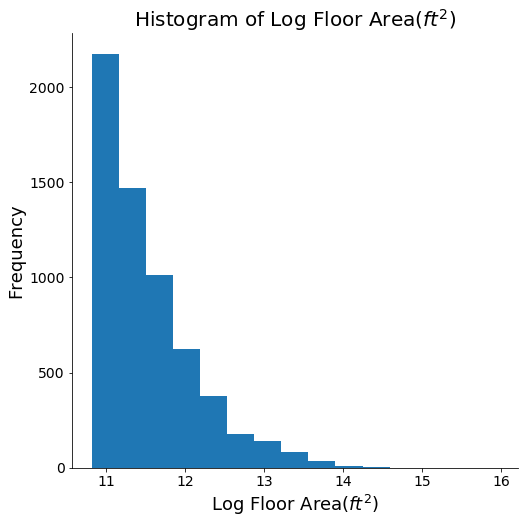

In [371]:
# Since scale of floor area, lot area and Weather normalized natural gas used are too big,
# I convert them into log value to better display their histogram.
fig = plt.figure(figsize=(8,8))
plt.hist(np.log(df4.Fl_ft2),bins=15)
plt.title('Histogram of Log Floor Area($ft^{2}$)', fontsize = 20)
plt.xlabel('Log Floor Area($ft^{2}$)')
plt.ylabel('Frequency')
fig.savefig('fig7.jpg')

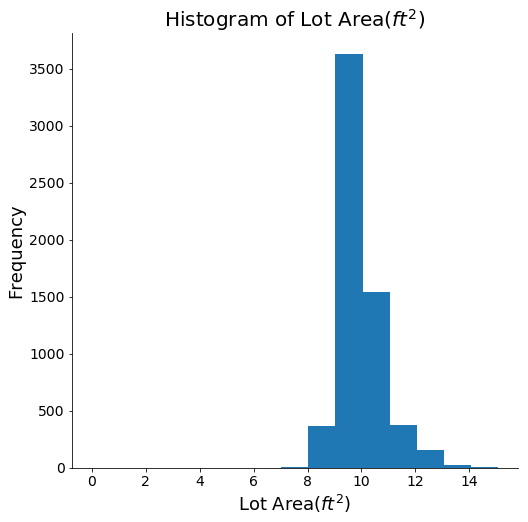

In [365]:
fig = plt.figure(figsize=(8,8))
plt.hist(np.log(df4.LotArea),bins=15)
plt.title('Histogram of Lot Area($ft^{2}$)', fontsize = 20)
plt.xlabel('Lot Area($ft^{2}$)')
plt.ylabel('Frequency')
fig.savefig('fig1.jpg')

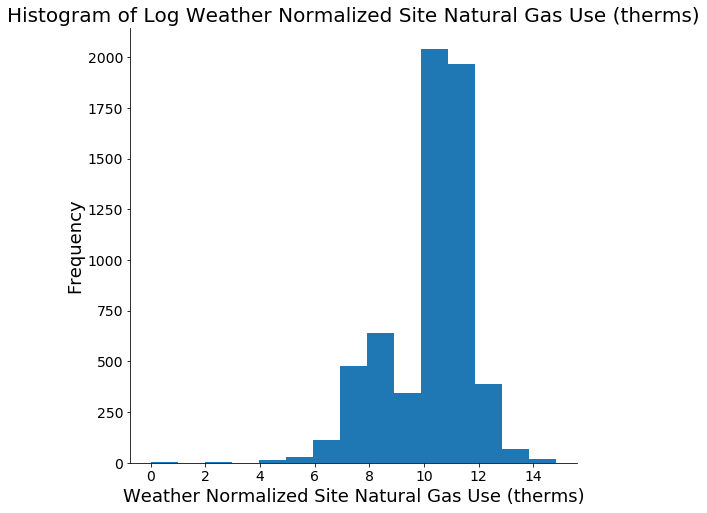

In [366]:
fig = plt.figure(figsize=(8,8))
plt.hist(np.log(df4.norm_gas),bins=15)
plt.title('Histogram of Log Weather Normalized Site Natural Gas Use (therms)', fontsize = 20)
plt.xlabel('Weather Normalized Site Natural Gas Use (therms)')
plt.ylabel('Frequency')
fig.savefig('fig2.jpg')

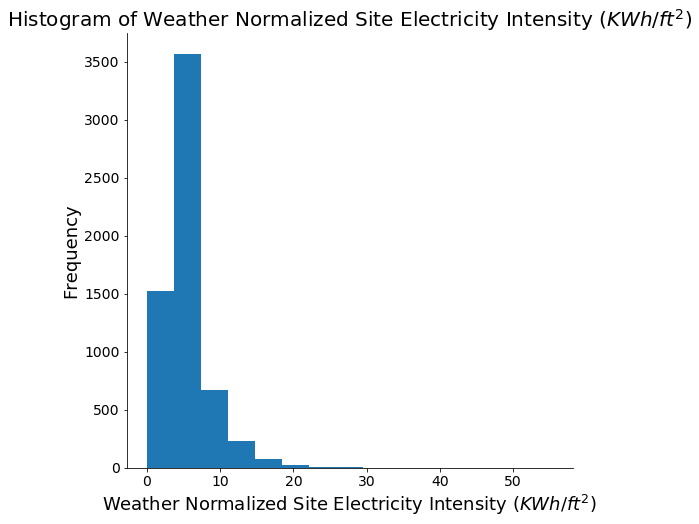

In [367]:
fig = plt.figure(figsize=(8,8))
plt.hist(df4.norm_elct,bins=15)
plt.title('Histogram of Weather Normalized Site Electricity Intensity ($KWh/ft^{2}$)', fontsize = 20)
plt.xlabel('Weather Normalized Site Electricity Intensity ($KWh/ft^{2}$)')
plt.ylabel('Frequency')
fig.savefig('fig3.jpg')

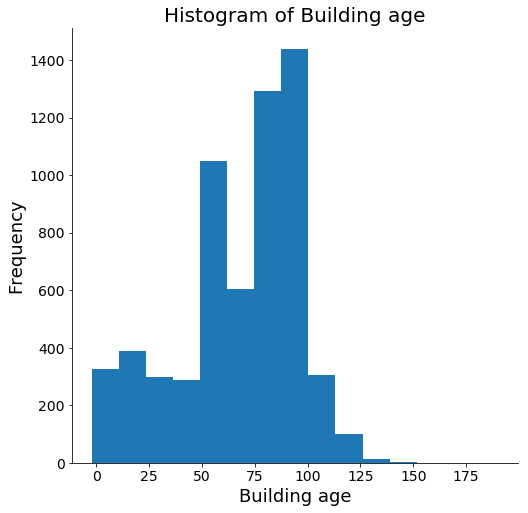

In [368]:
fig = plt.figure(figsize=(8,8))
plt.hist(df4.age,bins=15)
plt.title('Histogram of Building age', fontsize = 20)
plt.xlabel('Building age')
plt.ylabel('Frequency')
fig.savefig('fig4.jpg')

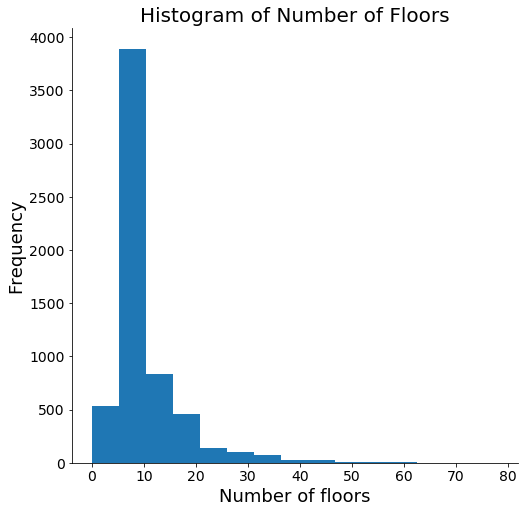

In [369]:
fig = plt.figure(figsize=(8,8))
plt.hist(df4.NumFloors,bins=15)
plt.title('Histogram of Number of Floors', fontsize = 20)
plt.xlabel('Number of floors')
plt.ylabel('Frequency')
fig.savefig('fig5.jpg')

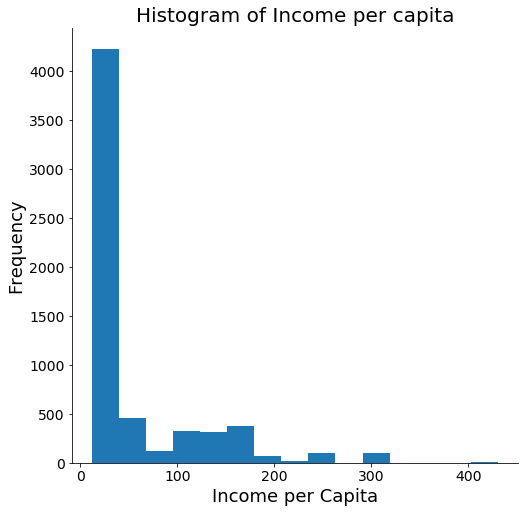

In [370]:
fig = plt.figure(figsize=(8,8))
plt.hist(df4.incomePC,bins=15)
plt.title('Histogram of Income per capita', fontsize = 20)
plt.xlabel('Income per Capita')
plt.ylabel('Frequency')
fig.savefig('fig6.jpg')

## Multivariate Regression Modeling

In [637]:
lm = smf.ols('eui ~ Fl_ft2 + age + LotArea + NumFloors + BuiltFAR + incomePC + norm_gas + norm_elct + d_ghg + id_ghg', 
                   data=df4).fit()

In [638]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    eui   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     242.7
Date:                Wed, 15 Nov 2017   Prob (F-statistic):               0.00
Time:                        20:28:53   Log-Likelihood:                -28063.
No. Observations:                6111   AIC:                         5.615e+04
Df Residuals:                    6100   BIC:                         5.622e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     53.4845      1.306     40.966      0.000      50.925      56.044
Fl_ft2     -2.857e-05   2.53e-06    -11.285      0.000   -3.35e-05   -2.36e-05
age            0.1655      0.012     13.799      0.000       0.142       0.189
LotArea     1.306e-05   4.09e-06      3.190      0.001    5.04e-06    2.11e-05
NumFloors      0.0402      0.066      0.608      0.543      -0.089       0.170
BuiltFAR       0.0055      0.010      0.538      0.591      -0.015       0.026
incomePC      -0.0820      0.006    -13.630      0.000      -0.094      -0.070
norm_gas   -1.265e-05   4.38e-06     -2.888      0.004   -2.12e-05   -4.07e-06
norm_elct      4.4101      0.124     35.601      0.000       4.167       4.653
d_ghg          0.0173      0.001     25.417      0.000       0.016       0.019
id_ghg        -0.0078      0.001     -6.582      0.000      -0.010      -0.005
==============================================================================
Omnibus:                     1134.029   Durbin-Watson:                   1.732
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8187.237
Skew:                           0.696   Prob(JB):                         0.00
Kurtosis:                       8.497   Cond. No.                     1.13e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [378]:
# Since the coefficients of floor area, lot area and Weather normalized natural gas used are too small,
# I convert them into log value to better display their impact on EUI.
df4['log_fl_ft2'] = np.log(df4.Fl_ft2)
df4['log_LotArea'] = np.log(df4.LotArea)
df4['log_norm_gas'] = np.log(df4.norm_gas)

In [635]:
lm2 = smf.ols('eui ~ log_fl_ft2 + age + log_LotArea + BuiltFAR + log_norm_gas + NumFloors + incomePC + norm_elct + d_ghg + id_ghg', 
                   data=df4).fit()

In [636]:
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    eui   R-squared:                       0.310
Model:                            OLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                     273.9
Date:                Wed, 15 Nov 2017   Prob (F-statistic):               0.00
Time:                        20:28:47   Log-Likelihood:                -27953.
No. Observations:                6111   AIC:                         5.593e+04
Df Residuals:                    6100   BIC:                         5.600e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      172.0700      8.846     19.452      0.000     154.729     189.411
log_fl_ft2     -20.3567      1.111    -18.317      0.000     -22.535     -18.178
age              0.1915      0.012     15.773      0.000       0.168       0.215
log_LotArea      8.1662      0.686     11.913      0.000       6.822       9.510
BuiltFAR         0.0354      0.011      3.329      0.001       0.015       0.056
log_norm_gas     2.1210      0.229      9.253      0.000       1.672       2.570
NumFloors        0.6359      0.076      8.314      0.000       0.486       0.786
incomePC        -0.0412      0.006     -6.497      0.000      -0.054      -0.029
norm_elct        4.4899      0.121     37.198      0.000       4.253       4.726
d_ghg            0.0148      0.000     30.329      0.000       0.014       0.016
id_ghg          -0.0095      0.001     -8.597      0.000      -0.012      -0.007
==============================================================================
Omnibus:                     1210.265   Durbin-Watson:                   1.747
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6660.597
Skew:                           0.838   Prob(JB):                         0.00
Kurtosis:                       7.832   Cond. No.                     2.94e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.94e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### R2 is right above 0.3 which make this regression model acceptable to do EUI prediction.

In [381]:
df4['predicted_eui'] = lm2.predict()
df4.describe()

,Fl_ft2,LotArea,NumFloors,norm_gas,BuiltFAR,incomePC,ENERGY STAR Score,eui,log_eui,ZIPCODE,d_ghg,id_ghg,norm_elct,age,predicted_eui,diff_eui,log_fl_ft2,log_LotArea,log_norm_gas
count,6.111000e+03,6.111000e+03,6111.000000,6.111000e+03,6111.000000,6111.000000,6111.000000,6111.000000,6111.000000,6111.000000,6111.000000,6111.000000,6111.000000,6111.000000,6111.000000,6.111000e+03,6111.000000,6111.000000,6111.000000
mean,1.315592e+05,3.576667e+04,9.537392,6.605364e+04,6.175163,56.177469,56.675994,86.657650,1.915042,10665.423335,490.400409,248.188971,5.393291,67.396662,86.657650,-7.069586e-12,11.521022,9.957214,10.277653
std,1.917451e+05,8.779169e+04,7.138915,1.254147e+05,29.930667,65.792505,29.161205,28.241933,0.144332,564.352962,791.420391,443.709146,3.067970,28.241020,15.721046,2.346179e+01,0.614646,0.815820,1.531733
min,5.002800e+04,1.000000e+00,0.000000,1.000000e+00,0.000000,12.070212,1.000000,21.000000,1.322219,10001.000000,0.000000,0.000000,0.000000,-2.000000,18.645360,-1.670976e+02,10.820338,0.000000,0.000000
25%,6.379900e+04,1.277000e+04,6.000000,1.556350e+04,3.490000,17.755575,34.000000,69.700000,1.843233,10032.000000,235.500000,79.900000,3.650000,53.000000,79.188942,-1.129486e+01,11.063493,9.454854,9.652684
50%,8.453000e+04,1.787900e+04,6.000000,4.533420e+04,4.350000,25.040403,61.000000,83.300000,1.920645,10463.000000,336.300000,120.200000,4.600000,76.000000,85.242028,1.868613e+00,11.344862,9.791382,10.721817
75%,1.346770e+05,2.872250e+04,12.000000,7.080895e+04,6.390000,64.167478,81.000000,100.100000,2.000434,11226.000000,510.200000,222.850000,6.200000,89.000000,92.058787,1.287674e+01,11.810633,10.265436,11.167741
max,8.512479e+06,3.464089e+06,78.000000,2.809931e+06,2088.000000,430.402252,100.000000,294.800000,2.469527,11694.000000,28090.100000,7698.100000,55.400000,190.000000,451.593528,1.567935e+02,15.957044,15.057960,14.848671


In [633]:
lm_1 = smf.ols('predicted_eui ~ eui', data=df4).fit()

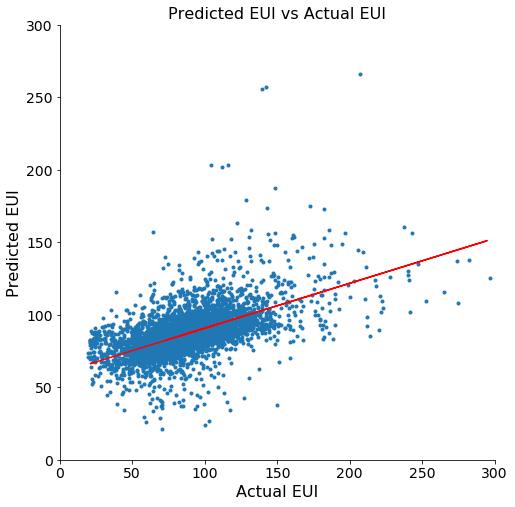

In [634]:
fig = plt.figure(figsize=(13,8))
plt.plot(df_.norm_eui, lm2.predict(),'.')
plt.plot(df4.eui, lm_1.predict() ,'r-')
plt.xlabel('Actual EUI', fontsize=16)
plt.ylabel('Predicted EUI', fontsize=16)
plt.title('Predicted EUI vs Actual EUI', fontsize=16)
plt.xlim(0, 300)
plt.ylim(0, 300)
plt.gca().set_aspect('equal', adjustable='box')
fig.savefig('fig8.jpg')

#### Limitation: 
#### It seems that the regression model's predictions underestimate EUI in general. 


In [382]:
df4['diff_eui'] = df4.predicted_eui - df4.eui

In [383]:
df4['diff_eui'].describe()

count    6.111000e+03
mean    -7.069586e-12
std      2.346179e+01
min     -1.670976e+02
25%     -1.129486e+01
50%      1.868613e+00
75%      1.287674e+01
max      1.567935e+02
Name: diff_eui, dtype: float64

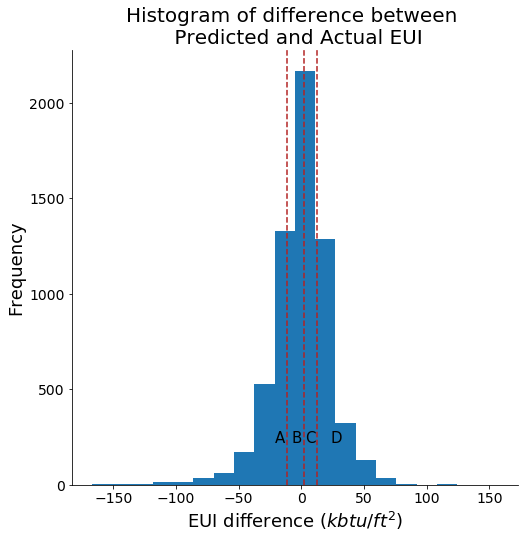

In [641]:
fig = plt.figure(figsize=(8,8))
plt.hist(df4['diff_eui'],bins = 20)
for label, pos in zip(['A', 'B', 'C'], df4['diff_eui'].describe()[4:7].values):
    plt.axvline(x=pos, color='firebrick', linestyle='--')
    plt.text(pos-10, 220, label, fontsize=15)
plt.text(pos+10, 220, 'D', fontsize=15)
plt.title('Histogram of difference between \n Predicted and Actual EUI', fontsize = 20)
plt.xlabel('EUI difference ($kbtu/ft^{2}$)')
plt.ylabel('Frequency')
fig.savefig('fig9.jpg')

In [342]:
df4.head()

,Fl_ft2,LotArea,NumFloors,norm_gas,BuiltFAR,incomePC,ENERGY STAR Score,eui,log_eui,ZIPCODE,d_ghg,id_ghg,norm_elct,age,predicted_eui,diff_eui
0,98052.0,18375,11.0,55261.4,5.34,21.312824,87.0,73.7,1.867467,10002,290.2,146.1,5.3,35,81.169556,7.469556
3,60417.0,16665,5.0,53110.6,3.63,21.312824,63.0,108.7,2.036230,10002,282.1,138.0,7.3,84,104.586993,-4.113007
4,627895.0,113690,26.0,425345.9,5.52,21.312824,49.0,82.2,1.914872,10002,2195.5,872.0,4.9,38,92.274110,10.074110
5,260000.0,49116,21.0,145623.9,5.29,21.312824,52.0,87.1,1.940018,10002,880.9,556.0,7.4,22,89.563974,2.463974
6,83904.0,20095,10.0,86468.8,4.18,21.312824,22.0,121.7,2.085291,10002,453.1,139.1,5.9,30,89.566396,-32.133604


In [261]:
#normalize the diff_eui by cutting records from upper and lower bounds
df5 = df4[(df4['diff_eui']>-50) & (df4['diff_eui']<50)]

In [264]:
df5['diff_eui'] = df5['diff_eui'] + 50 #generate score centralized by 50 and in range(0,100)

/Users/zhoubaoling/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [266]:
df5.diff_eui.describe()

count    5845.000000
mean       50.980299
std        18.130766
min         0.492606
25%        39.842523
50%        52.077234
75%        62.500285
max        99.842798
Name: diff_eui, dtype: float64

In [267]:
#output df5 as a csv file for Tableau Mapping.
df5.to_csv('map.csv')

In [269]:
print('The remaining dataset has %d records.'%len(df5))

The remaining dataset has 5845 records.


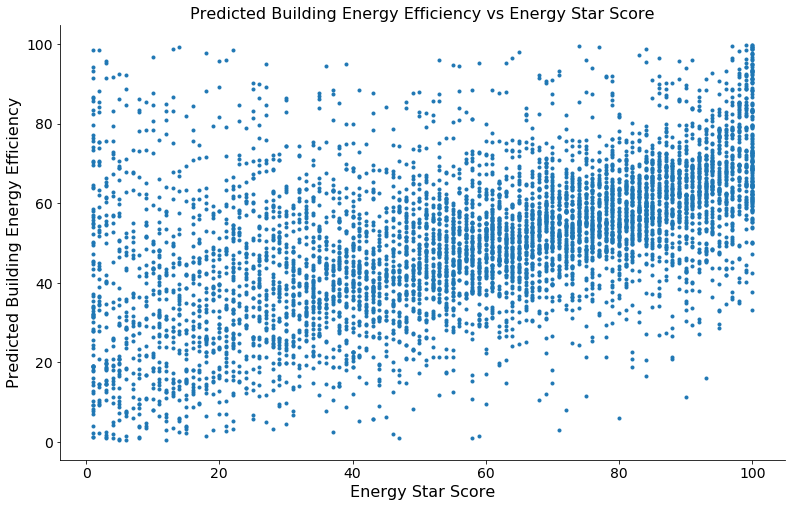

In [600]:
fig = plt.figure(figsize=(13,8))
plt.plot(df5['ENERGY STAR Score'], df5.diff_eui,'.')
plt.xlabel('Energy Star Score', fontsize=16)
plt.ylabel('Predicted Building Energy Efficiency', fontsize=16)
plt.title('Predicted Building Energy Efficiency vs Energy Star Score', fontsize=16)
#plt.xlim(0, 300)
#plt.ylim(0, 300)
#plt.gca().set_aspect('equal', adjustable='box')
fig.savefig('fig10.jpg')

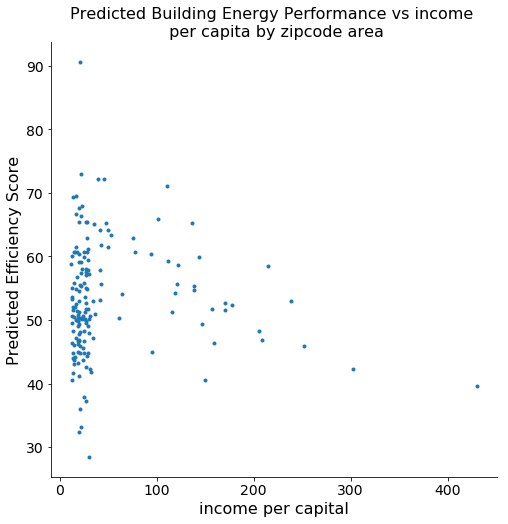

In [644]:
fig = plt.figure(figsize=(8,8))
plt.plot(df6['incomePC'], df6['Predicted Efficiency Score'],'.')
plt.xlabel('income per capital', fontsize=16)
plt.ylabel('Predicted Efficiency Score', fontsize=16)
plt.title('Predicted Building Energy Performance vs income \n per capita by zipcode area', fontsize=16)
#plt.xlim(0, 300)
#plt.ylim(0, 300)
#plt.gca().set_aspect('equal', adjustable='box')
fig.savefig('fig13.jpg')

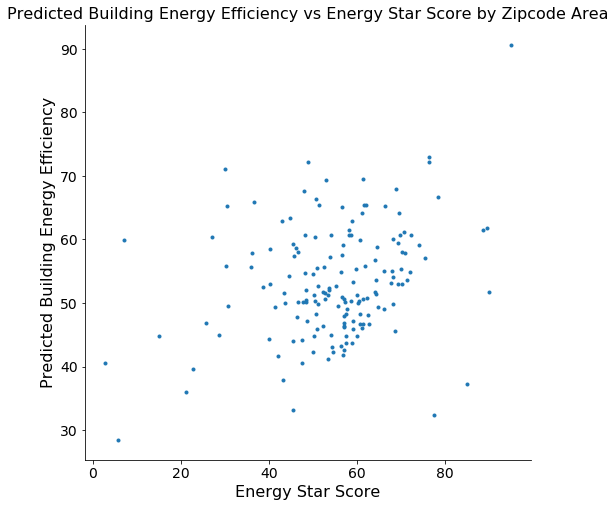

In [609]:
plt.plot(df6['ENERGY STAR Score'],df6['Predicted Efficiency Score'],'.')
plt.xlabel('Energy Star Score', fontsize=16)
plt.ylabel('Predicted Building Energy Efficiency', fontsize=16)
plt.title('Predicted Building Energy Efficiency vs Energy Star Score by Zipcode Area', fontsize=16)

In [395]:
df6 = df5.groupby('ZIPCODE').mean()
df6.head()

,Fl_ft2,LotArea,NumFloors,norm_gas,BuiltFAR,incomePC,ENERGY STAR Score,eui,log_eui,d_ghg,id_ghg,norm_elct,age,log_fl_ft2,log_LotArea,log_norm_gas,predicted_eui,diff_eui
ZIPCODE,,,,,,,,,,,,,,,,,,
10001,177611.567568,14713.783784,18.567568,69569.556757,11.488919,94.386319,50.378378,76.151351,1.860734,461.616216,467.000000,7.951351,52.945946,11.809252,9.413528,10.111330,86.562024,60.410672
10002,261992.565217,57520.739130,12.130435,141785.230435,5.190870,21.312824,50.826087,89.513043,1.931119,859.078261,680.286957,8.278261,43.478261,12.012161,10.403777,11.187579,95.017459,55.504416
10003,119848.769231,14785.969231,12.892308,44882.710769,8.695692,119.356720,44.523077,89.395385,1.927110,413.540000,337.413846,8.752308,72.215385,11.573104,9.435276,9.682464,93.706990,54.311605
10004,271133.750000,14488.000000,25.500000,32299.750000,14.030000,150.291551,2.750000,116.575000,2.062046,420.625000,1332.600000,15.175000,67.250000,12.245744,9.497503,10.236455,107.143028,40.568028
10005,476526.400000,20186.400000,33.000000,100045.300000,24.118000,430.402252,22.800000,75.380000,1.870603,572.140000,1625.840000,9.200000,80.800000,12.927267,9.728129,10.687536,64.924302,39.544302


In [506]:
df6.rename(columns={'diff_eui': 'Predicted Efficiency Score'}, inplace=True)

In [548]:
outliner1 = df6[df6['eui'] < 40]

In [533]:
outliner2 = df6[df6.eui > 160]

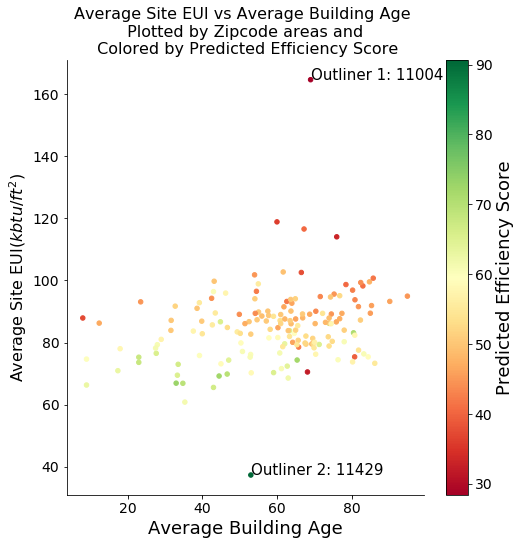

In [645]:
plt.figure(figsize=(15,15))
ax = df6.plot(kind='scatter',x='age',y='eui',c='Predicted Efficiency Score',cmap='RdYlGn')
#plt.gca().set_aspect('equal', adjustable='box')
#plt.xlim(0, 180)
#plt.ylim(0, 180)
#ax.set_xticks([0,20,40,60,80,100,120,140,160,180])
#ax.set_xticks([0,5,10,20,25,30,35,40,45,50])
#axes.set_xticklabels(['20','40','60','80','100','120','140','160','180'])
#a=axes.get_yticks().tolist()
#a = ['20','40','60','80','100','120','140','160','180']
#axes.set_xticklabels(a)
plt.setp(ax.get_xticklabels(), visible=True)
plt.setp(ax.set_xlabel('Average Building Age'), visible=True)
#ax.set_xlabel('Actual EUI', fontsize=16)
plt.ylabel('Average Site EUI($kbtu/ft^{2}$)', fontsize=16)
plt.title('Average Site EUI vs Average Building Age \n Plotted by Zipcode areas and \n Colored by Predicted Efficiency Score', fontsize=16)
ax.annotate('Outliner 2: %d'%outliner1.index[0], xy=(outliner1.age,outliner1.eui), fontsize = 15)
ax.annotate('Outliner 1: %d'%outliner2.index[0], xy=(outliner2.age,outliner2.eui), fontsize = 15)
#cbar = fig.colorbar(cax,ticks=[0,50,100])
#cbar.ax.set_yticklabels([1,2,3])

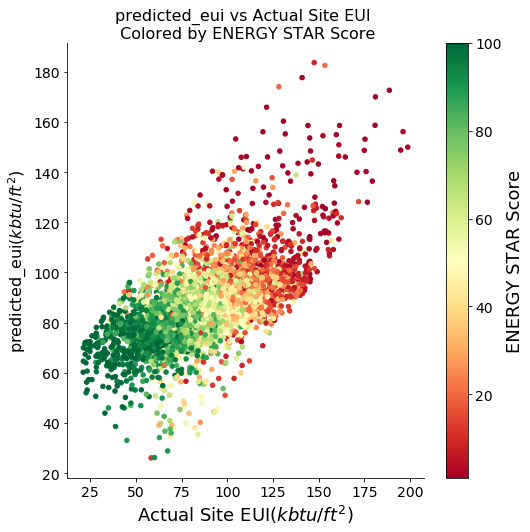

In [571]:
plt.figure(figsize=(15,15))
ax = df5.plot(kind='scatter',x='eui',y='predicted_eui',c='ENERGY STAR Score',cmap='RdYlGn')
#plt.gca().set_aspect('equal', adjustable='box')
#plt.xlim(0, 180)
#plt.ylim(0, 180)
#ax.set_xticks([0,20,40,60,80,100,120,140,160,180])
#ax.set_xticks([0,5,10,20,25,30,35,40,45,50])
#axes.set_xticklabels(['20','40','60','80','100','120','140','160','180'])
#a=axes.get_yticks().tolist()
#a = ['20','40','60','80','100','120','140','160','180']
#axes.set_xticklabels(a)
plt.setp(ax.get_xticklabels(), visible=True)
plt.setp(ax.set_xlabel('Actual Site EUI($kbtu/ft^{2}$)'), visible=True)
#ax.set_xlabel('Actual EUI', fontsize=16)
plt.ylabel('predicted_eui($kbtu/ft^{2}$)', fontsize=16)
plt.title('predicted_eui vs Actual Site EUI \n Colored by ENERGY STAR Score', fontsize=16)
#ax.annotate('Outliner 2: %d'%outliner1.index[0], xy=(outliner1.age,outliner1.eui), fontsize = 15)
#ax.annotate('Outliner 1: %d'%outliner2.index[0], xy=(outliner2.age,outliner2.eui), fontsize = 15)
#cbar = fig.colorbar(cax,ticks=[0,50,100])
#cbar.ax.set_yticklabels([1,2,3])